In [29]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
import math
from math import gcd # greatest common divisor

register1 = 0
register2 = 0
a = 2
N = 35


In [30]:
def setAmtQubits(N):
    T1 = N*N
    t1 = bin(T1)
    global register1 
    register1 = int(len(t1)-2)
    global register2
    register2 = math.ceil(math.log2(N))


In [31]:
setAmtQubits(N)

print(register1)
print(register2)

11
6


In [32]:
def qpe_amod(a):
    n_count = register1
    aux_count = register2
    qc = QuantumCircuit(aux_count+n_count, n_count)
    
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(aux_count-1+n_count) # And auxiliary register in state |1>
    
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod(a, 2**q,aux_count), 
                 [q] + [i+n_count for i in range(aux_count)])
        
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    
    qc.measure(range(n_count), range(n_count))
    (qc.draw(fold=-1))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    result = aer_sim.run(t_qc, shots=1, memory=True).result()
    readings = result.get_memory()
    print("Register Reading: " + readings[0])
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

In [33]:
def c_amod(a, power,aux_count):
    U = QuantumCircuit(aux_count)        
    for iteration in range(power):
        i = 0
        j = 1
        while i < (aux_count - 1):
            U.swap(i,j)
            i = i + 1
            j = j + 1
        
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U


In [34]:
def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [35]:
phase = qpe_amod(a) # Phase = s/r

Fraction(phase).limit_denominator(15) 

frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)


guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True

Register Reading: 10101010101
Corresponding Phase: 0.666504
3
[1, 1]

Attempt 1:
Register Reading: 01010101011
Corresponding Phase: 0.333496
Result: r = 3
Guessed Factors: 1 and 1

Attempt 2:
Register Reading: 01010101100
Corresponding Phase: 0.333984
Result: r = 3
Guessed Factors: 1 and 1

Attempt 3:
Register Reading: 10000000000
Corresponding Phase: 0.500000
Result: r = 2
Guessed Factors: 1 and 1

Attempt 4:
Register Reading: 11010101010
Corresponding Phase: 0.833008
Result: r = 6
Guessed Factors: 1 and 1

Attempt 5:
Register Reading: 11010101011
Corresponding Phase: 0.833496
Result: r = 6
Guessed Factors: 1 and 1

Attempt 6:


KeyboardInterrupt: 

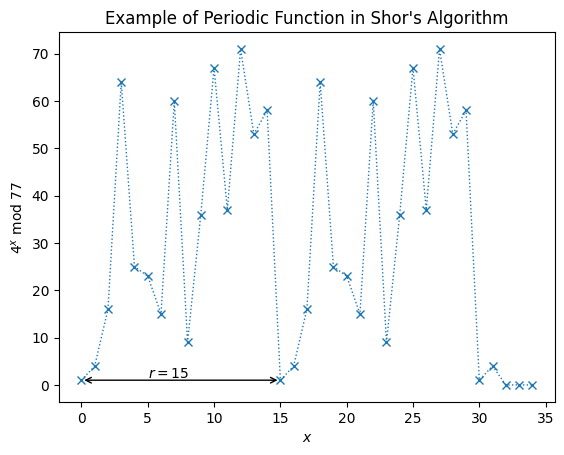

In [46]:
N = 77
a = 4

# Calculate the plotting data
xvals = np.arange(35)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel='$%i^x$ mod $%i$' % (a, N),
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) +1 
    plt.annotate('', xy=(0,1), xytext=(r,1), arrowprops=dict(arrowstyle='<->'))
    plt.annotate('$r=%i$' % r, xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')